#Imports

In [3]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from datetime import datetime

# from google.colab import drive
# drive.mount('/content/gdrive')

# Parameters

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

pixels = 28
batch_size = 64
log_interval = 780
epochs = 100
bottleneck_dim = 200
use_conv = True
plot_images = True
plot_loss = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: C:\Users\n\Documents\Deep Learning\02456_DL-sketch_features_VAE


# Load data

## MNIST binary

In [5]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

## Quick, Draw!

In [6]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = pixels, pixels, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        print(data.shape)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    data_dir = "../quickdraw"
    #data_dir = "gdrive/My Drive/DTU/Semester 2"
    # categories = ['cat', 'banana']
#     categories = ['cat', 'pig']
    categories = ['bucket', 'palm tree', 'necklace', 'ice cream', 'butterfly', 'umbrella', 'boomerang', 'pig', 'cat', 'car']

    xpixels = pixels
    ypixels = pixels

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 20000  # number of training images from each category
    n_take_test = 5000   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            img = np.invert(img)
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [7]:
# LOAD BINARY MNIST
# x_train, x_valid, x_test = get_binmnist_datasets(root)

# train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
# test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [8]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/10] Reading category index 0: 'bucket' (124064 images: take 20000 training, take 5000 test)
[2/10] Reading category index 1: 'palm tree' (121959 images: take 20000 training, take 5000 test)
[3/10] Reading category index 2: 'necklace' (120580 images: take 20000 training, take 5000 test)
[4/10] Reading category index 3: 'ice cream' (123133 images: take 20000 training, take 5000 test)
[5/10] Reading category index 4: 'butterfly' (117999 images: take 20000 training, take 5000 test)
[6/10] Reading category index 5: 'umbrella' (124084 images: take 20000 training, take 5000 test)
[7/10] Reading category index 6: 'boomerang' (142682 images: take 20000 training, take 5000 test)
[8/10] Reading category index 7: 'pig' (186770 images: take 20000 training, take 5000 test)
[9/10] Reading category index 8: 'cat' (123202 images: take 20000 training, take 5000 test)
[10/10] Reading category index 9: 'car' (182764 images: take 20000 training, take 5000 test)
(200000, 28, 28, 1)
(50000, 28, 28, 1)


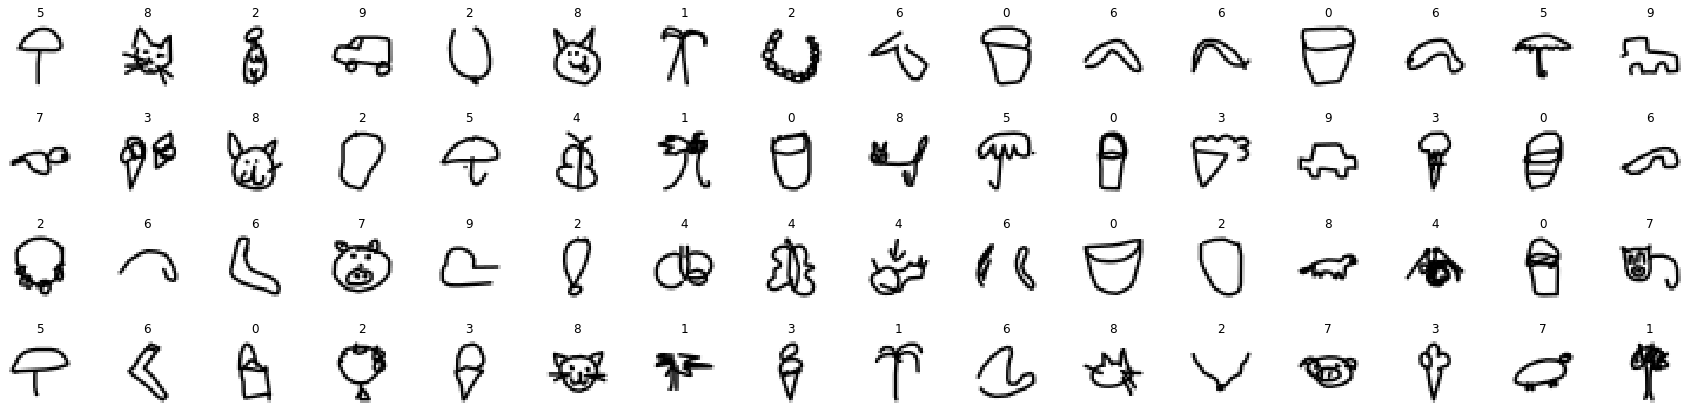

In [27]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(pixels*pixels, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, pixels*pixels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, pixels*pixels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [9]:
ngf = 64
ndf = 64
nc = 1
h_dim=1024

stride = 2
pad = 1
k_dim = 4

class conv_VAE(nn.Module):
    def __init__(self, nz=32):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, k_dim, stride, pad, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf) x 14 x 14 (25)
            nn.Conv2d(ndf, ndf * 2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf*2) x 7 x 7 (21)
            nn.Conv2d(ndf * 2, ndf * 4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), #
            
            # state size. (ndf*8) x 4 x 4 (14)
            nn.Conv2d(ndf * 4, 1024, k_dim, stride-1, pad-1, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU() # 
            # nn.Sigmoid()
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(1024, ngf*8, k_dim, stride, pad-1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True), # nn.ReLU(), # 
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*4, ngf*2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*2, nc, k_dim, stride, pad, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        # print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
        # print("z", z.size())
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

# Loss function

In [10]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, pixels*pixels), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()
    # return BCE + KLD, BCE, kl.mean()


# Train

In [11]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0
    # batch_elbo = []

    for data, _ in train_loader:
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [12]:
def test(epoch):
    if epoch == 1:
        show_img = True
    else:
        show_img = True if epoch % 10 == 0 else False
        
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        for data, _ in test_loader: 
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_all_images(data, recon_batch, 32)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [13]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples for 
def plot_all_images(data, recon_batch, bottleneck_dim):

    f, axarr = plt.subplots(1, 3, figsize=(24, 8))
    rows = 8
    columns = batch_size // rows

    # -- Inputs -- 
    ax = axarr[0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = data[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Reconstructions -- 
    ax = axarr[1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon_batch[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Latent space samples --
    ax = axarr[2]
    ax.set_title('Latent Space Samples')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(64, bottleneck_dim).to(device)
        samples = model.decode(epsilon).cpu()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    plt.show()


C:\Users\n\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [14]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    # ELBO loss
    ax1.set_title("ELBO loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

In [15]:

# def plot_interpolated_images(images):

#     f, axarr = plt.subplots(6, 5, figsize=(24, 6))

#     # vae_path = "gdrive/My Drive/animations/Apple/vae"
#     # vae_path = "gdrive/My Drive/animations/TrianRec/vae"
#     vae_path = "gdrive/My Drive/animations/RecCirc/vae"

#     #f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
#     f.tight_layout()

#     for i, ax in enumerate(axarr.flat):
#         ax.imshow(images[i].view(28, 28), cmap="binary_r")
#         save_image(images[i], os.path.join(vae_path, f"img_{i}.png"))
#         ax.axis('off')
#     plt.show()

def plot_interpolated_images(images):

    f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
    f.tight_layout()

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(28, 28), cmap="binary_r")
        ax.axis('off')
    plt.show()

# Main

C:\Users\n\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until


Train Epoch: 1 [0/200000 (0%)]	Loss: 922.921204
Train Epoch: 1 [49920/200000 (25%)]	Loss: 221.920059
Train Epoch: 1 [99840/200000 (50%)]	Loss: 208.503021
Train Epoch: 1 [149760/200000 (75%)]	Loss: 201.009872
Train Epoch: 1 [199680/200000 (100%)]	Loss: 206.286850
====> Epoch: 1 Average loss: 218.6382


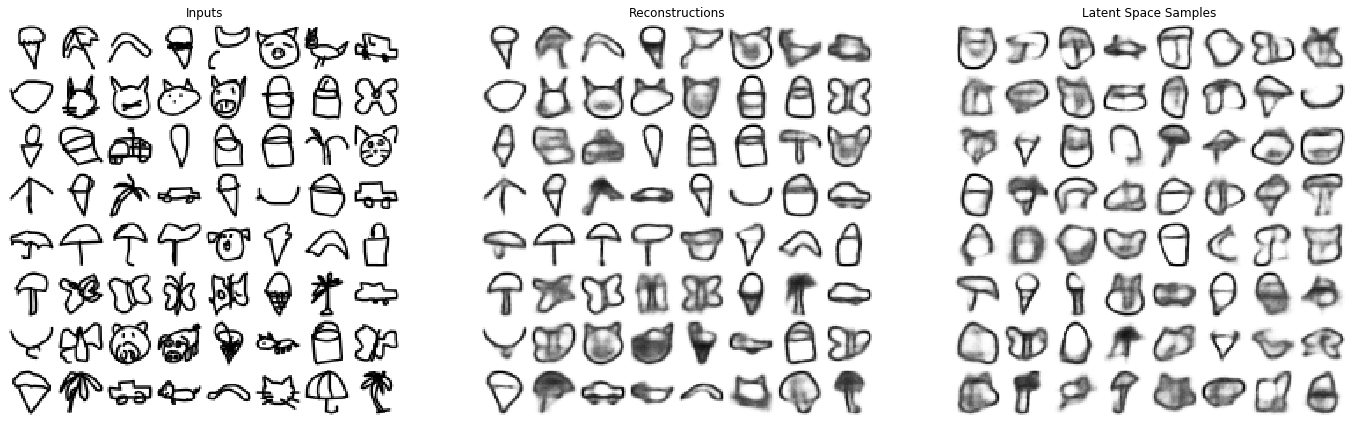

C:\Users\n\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until


====> Test set loss: 197.2715
Train Epoch: 2 [0/200000 (0%)]	Loss: 198.575317
Train Epoch: 2 [49920/200000 (25%)]	Loss: 195.576996
Train Epoch: 2 [99840/200000 (50%)]	Loss: 207.232162
Train Epoch: 2 [149760/200000 (75%)]	Loss: 184.421982
Train Epoch: 2 [199680/200000 (100%)]	Loss: 190.241928
====> Epoch: 2 Average loss: 194.7967
====> Test set loss: 191.4174
########################################################
Train Epoch: 3 [0/200000 (0%)]	Loss: 193.968170
Train Epoch: 3 [49920/200000 (25%)]	Loss: 183.752106
Train Epoch: 3 [99840/200000 (50%)]	Loss: 188.565170
Train Epoch: 3 [149760/200000 (75%)]	Loss: 194.162323
Train Epoch: 3 [199680/200000 (100%)]	Loss: 184.607986
====> Epoch: 3 Average loss: 189.8946
====> Test set loss: 188.1655
########################################################
Train Epoch: 4 [0/200000 (0%)]	Loss: 187.475662
Train Epoch: 4 [49920/200000 (25%)]	Loss: 191.307190
Train Epoch: 4 [99840/200000 (50%)]	Loss: 184.935333
Train Epoch: 4 [149760/200000 (75%)]	Los

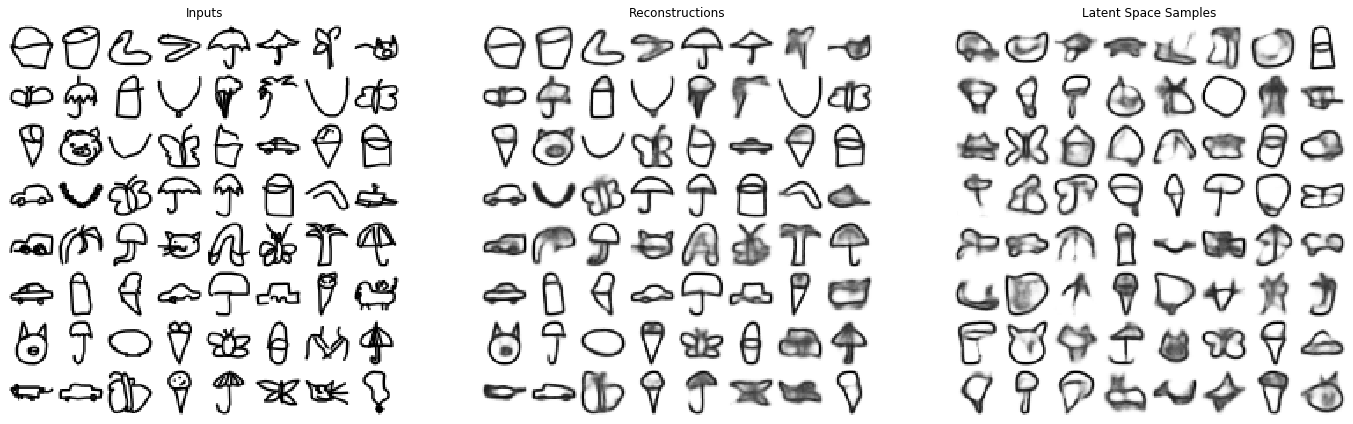

====> Test set loss: 180.3952


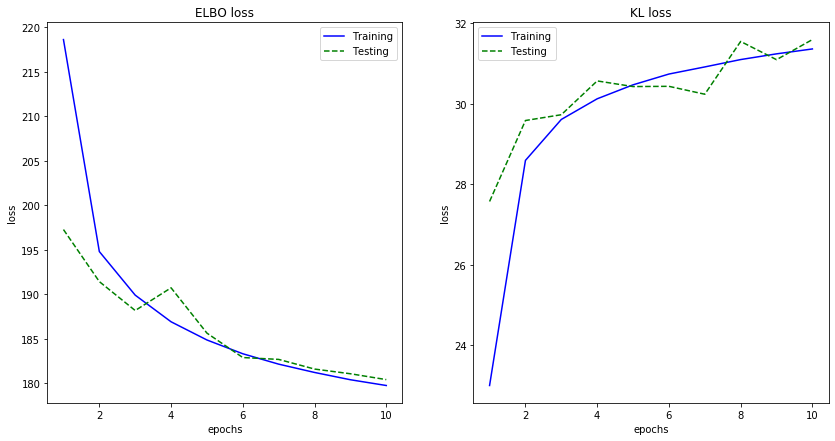

########################################################
Train Epoch: 11 [0/200000 (0%)]	Loss: 186.418884
Train Epoch: 11 [49920/200000 (25%)]	Loss: 174.120804
Train Epoch: 11 [99840/200000 (50%)]	Loss: 180.978241
Train Epoch: 11 [149760/200000 (75%)]	Loss: 170.834778
Train Epoch: 11 [199680/200000 (100%)]	Loss: 178.158615
====> Epoch: 11 Average loss: 179.1032
====> Test set loss: 180.5804
########################################################
Train Epoch: 12 [0/200000 (0%)]	Loss: 165.864258
Train Epoch: 12 [49920/200000 (25%)]	Loss: 170.985916
Train Epoch: 12 [99840/200000 (50%)]	Loss: 160.721283
Train Epoch: 12 [149760/200000 (75%)]	Loss: 165.294266
Train Epoch: 12 [199680/200000 (100%)]	Loss: 176.582092
====> Epoch: 12 Average loss: 178.6010
====> Test set loss: 179.8909
########################################################
Train Epoch: 13 [0/200000 (0%)]	Loss: 172.128235
Train Epoch: 13 [49920/200000 (25%)]	Loss: 184.823502
Train Epoch: 13 [99840/200000 (50%)]	Loss: 170.18164

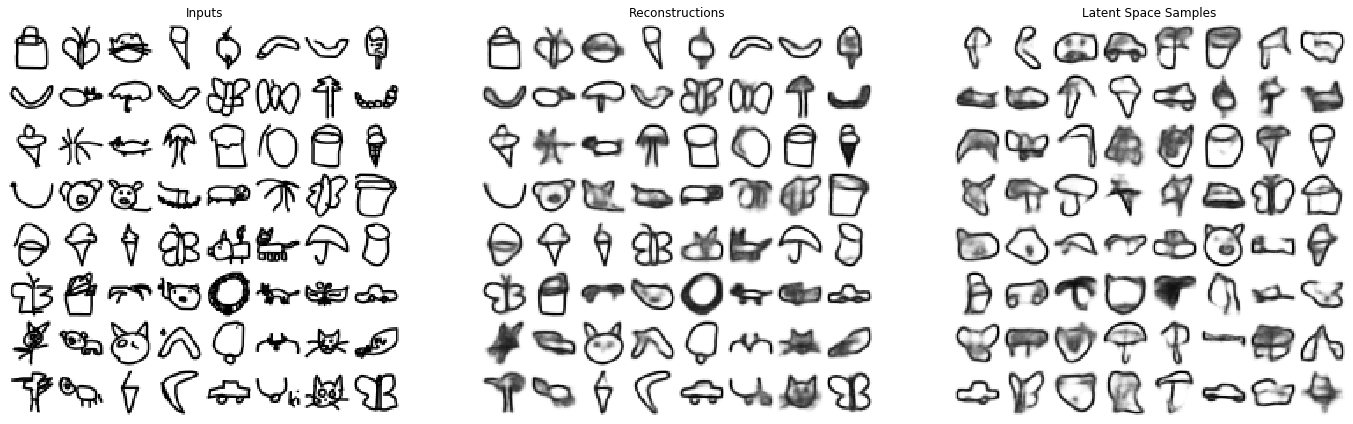

====> Test set loss: 178.5764


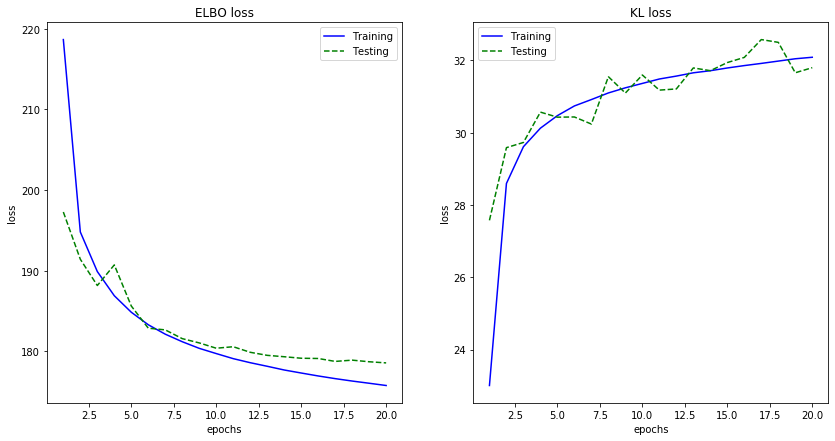

########################################################
Train Epoch: 21 [0/200000 (0%)]	Loss: 165.380142
Train Epoch: 21 [49920/200000 (25%)]	Loss: 173.013779
Train Epoch: 21 [99840/200000 (50%)]	Loss: 168.691895
Train Epoch: 21 [149760/200000 (75%)]	Loss: 184.994812
Train Epoch: 21 [199680/200000 (100%)]	Loss: 173.790161
====> Epoch: 21 Average loss: 175.5316
====> Test set loss: 178.0873
########################################################
Train Epoch: 22 [0/200000 (0%)]	Loss: 178.576599
Train Epoch: 22 [49920/200000 (25%)]	Loss: 175.145203
Train Epoch: 22 [99840/200000 (50%)]	Loss: 174.585983
Train Epoch: 22 [149760/200000 (75%)]	Loss: 174.143784
Train Epoch: 22 [199680/200000 (100%)]	Loss: 191.892014
====> Epoch: 22 Average loss: 175.2897
====> Test set loss: 177.9961
########################################################
Train Epoch: 23 [0/200000 (0%)]	Loss: 188.215851
Train Epoch: 23 [49920/200000 (25%)]	Loss: 170.813522
Train Epoch: 23 [99840/200000 (50%)]	Loss: 166.45607

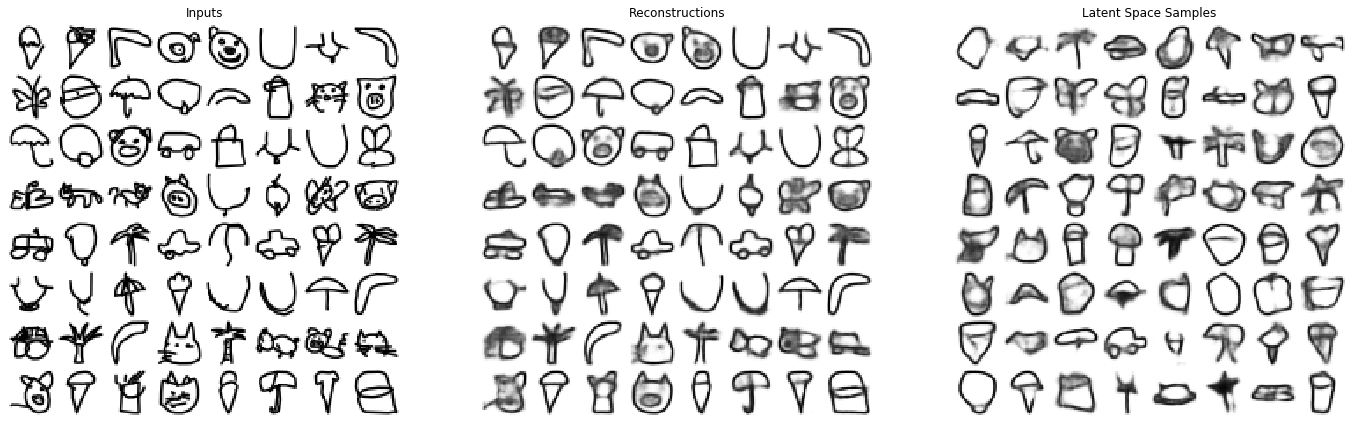

====> Test set loss: 177.7794


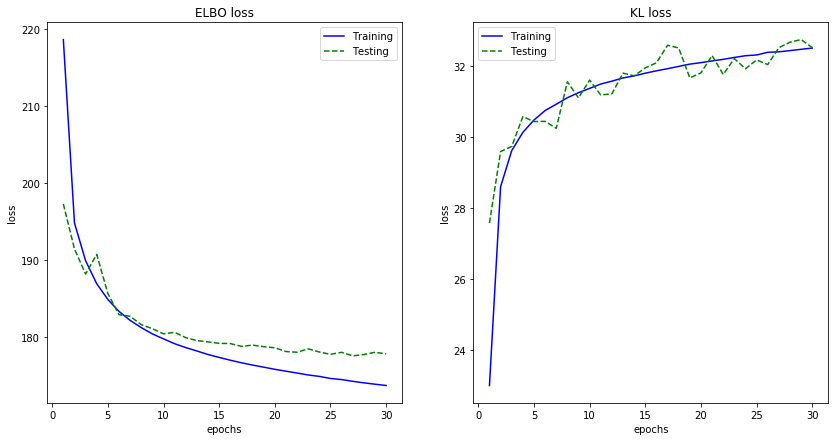

########################################################
Train Epoch: 31 [0/200000 (0%)]	Loss: 180.144394
Train Epoch: 31 [49920/200000 (25%)]	Loss: 174.507935
Train Epoch: 31 [99840/200000 (50%)]	Loss: 170.661743
Train Epoch: 31 [149760/200000 (75%)]	Loss: 187.734619
Train Epoch: 31 [199680/200000 (100%)]	Loss: 185.393524
====> Epoch: 31 Average loss: 173.5121
====> Test set loss: 177.3881
########################################################
Train Epoch: 32 [0/200000 (0%)]	Loss: 180.555511
Train Epoch: 32 [49920/200000 (25%)]	Loss: 176.892838
Train Epoch: 32 [99840/200000 (50%)]	Loss: 171.219849
Train Epoch: 32 [149760/200000 (75%)]	Loss: 168.559814
Train Epoch: 32 [199680/200000 (100%)]	Loss: 167.743134
====> Epoch: 32 Average loss: 173.3386
====> Test set loss: 177.6869
########################################################
Train Epoch: 33 [0/200000 (0%)]	Loss: 165.912933
Train Epoch: 33 [49920/200000 (25%)]	Loss: 176.680313
Train Epoch: 33 [99840/200000 (50%)]	Loss: 176.99469

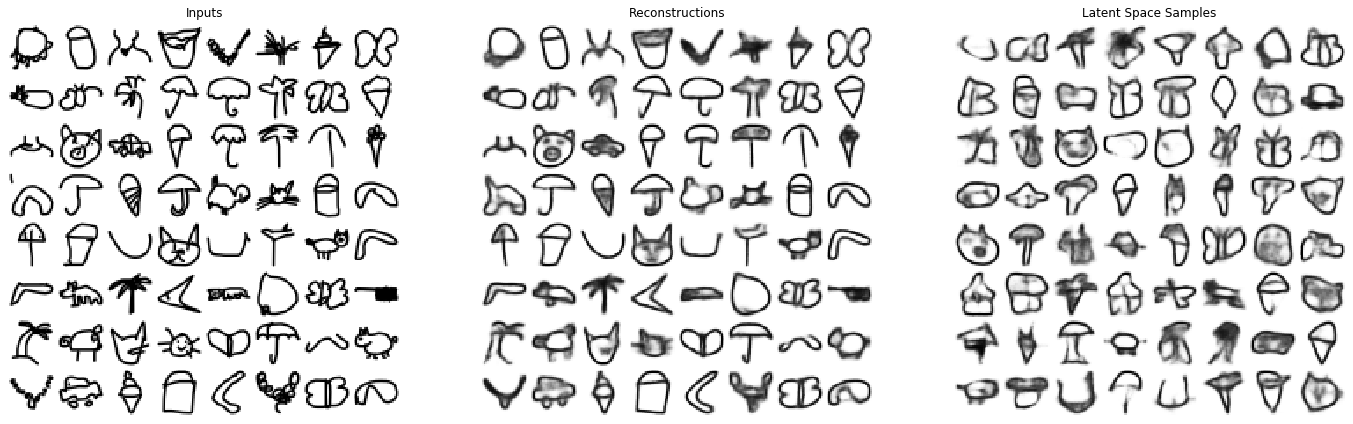

====> Test set loss: 177.1841


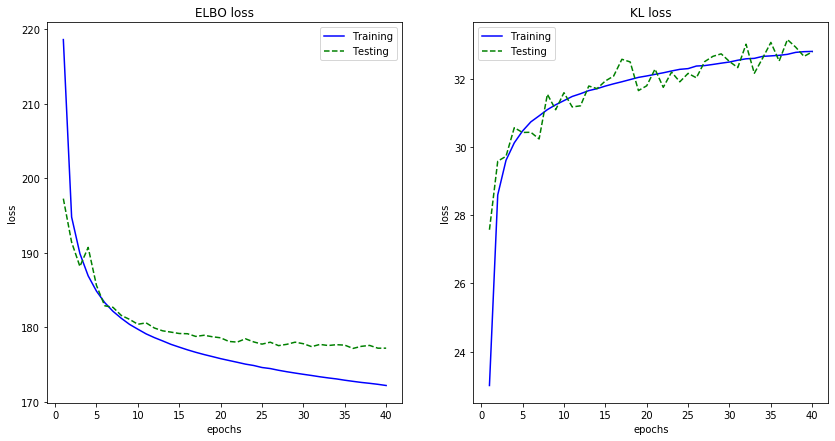

########################################################
Train Epoch: 41 [0/200000 (0%)]	Loss: 170.373779
Train Epoch: 41 [49920/200000 (25%)]	Loss: 174.163391
Train Epoch: 41 [99840/200000 (50%)]	Loss: 162.068878
Train Epoch: 41 [149760/200000 (75%)]	Loss: 175.177017
Train Epoch: 41 [199680/200000 (100%)]	Loss: 183.686966
====> Epoch: 41 Average loss: 172.0538
====> Test set loss: 177.4269
########################################################
Train Epoch: 42 [0/200000 (0%)]	Loss: 166.273117
Train Epoch: 42 [49920/200000 (25%)]	Loss: 174.008682
Train Epoch: 42 [99840/200000 (50%)]	Loss: 181.242645
Train Epoch: 42 [149760/200000 (75%)]	Loss: 171.124756
Train Epoch: 42 [199680/200000 (100%)]	Loss: 187.199951
====> Epoch: 42 Average loss: 171.9286
====> Test set loss: 177.3224
########################################################
Train Epoch: 43 [0/200000 (0%)]	Loss: 176.763031
Train Epoch: 43 [49920/200000 (25%)]	Loss: 170.178299
Train Epoch: 43 [99840/200000 (50%)]	Loss: 170.11492

KeyboardInterrupt: 

In [41]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue
            
        if epoch % 10 ==0:
            plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
            
        print("########################################################")
            
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        #clear_output(wait=True)


In [42]:
# Save the trained model
now = datetime.now()
current_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
filepath = os.path.join("gdrive/My Drive/model", f"trained_{current_datetime}.pt") 
filepath = os.path.join("./models", f"trained_{current_datetime}_10c.pt") 
torch.save(model.state_dict(), filepath)

# Interpolation

In [18]:
images, labels = next(iter(train_loader))

In [16]:
def interpolate(trn_model, images, idx_from, idx_to, steps):

    # get input images
    x_from = images[idx_from].unsqueeze(0)
    x_to = images[idx_to].unsqueeze(0)

    # anim_path = "gdrive/My Drive/animations/Apple/Apple_Animation"
    # anim_path = "gdrive/My Drive/animations/TrianRec/Animations"
#     anim_path = "gdrive/My Drive/animations/RecCirc/Animations"

#     image = Image.open(os.path.join(anim_path, 'Animation_00029.png'))
#     x = TF.to_tensor(TF.to_grayscale(image))
#     #x = np.invert(x)
#     x = x.unsqueeze(0)
#     x_from = x
    
#     image2 = Image.open(os.path.join(anim_path, 'Animation_00000.png'))
#     x2 = TF.to_tensor(TF.to_grayscale(image2))
#     #x2 = np.invert(x2)
#     x2 = x2.unsqueeze(0)
#     print(x2.shape)
#     x_to = x2

#     f, axarr = plt.subplots(1, 2, figsize=(16, 4))
#     f.tight_layout()

#     pic = x_from
#     for i, ax in enumerate(axarr.flat):
#         ax.imshow(x_from.view(28, 28), cmap="binary_r")
#         ax.axis('off')
#         pic = x_to
        
#     plt.show()


    interpolate_images(trn_model, x_from, x_to, steps)

def interpolate_images(trn_model, img_from, img_to, steps):

    # get labels
    # lab_to = labels[idx_to]
    # lab_from = labels[idx_from]  

    # get latent space representations of input images
    latent_from = trn_model.reparametrize(*trn_model.encode(img_from.to(device)))
    latent_to = trn_model.reparametrize(*trn_model.encode(img_to.to(device)))

    # actual steps including original images
    n = steps + 1 

    # initialize interpolation vector)
    inter = torch.zeros((n, latent_from.shape[1])).to(device)

    with torch.no_grad():
        alphaValues = np.linspace(0, 1, steps + 1)
        
        for i in range(n):
            alpha = alphaValues[i]
            inter[i] = latent_from * alpha + (1-alpha) * latent_to
        
        output = trn_model.decode(inter).cpu()
        plot_interpolated_images(output)

In [19]:
# Load the model for inference 
filepath = "./models/trained_26-11-2019_23-40-11_10c.pt"
trn_model = conv_VAE().to(device)
trn_model.load_state_dict(torch.load(filepath))
trn_model.eval()

conv_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3

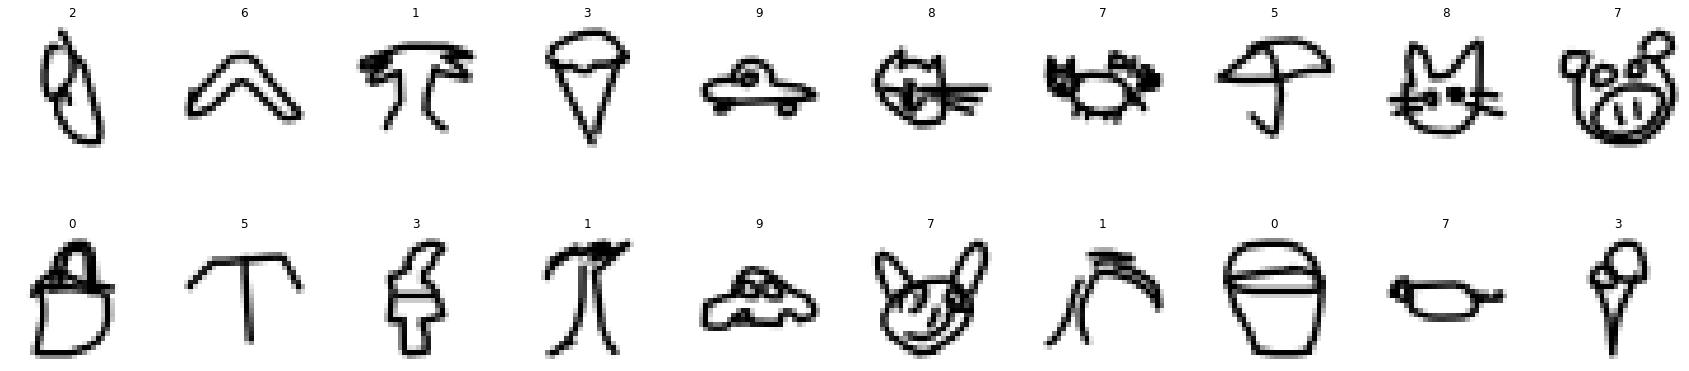

In [20]:
# Show possible images for interpolation
f, axarr = plt.subplots(2, 10, figsize=(24, 6))
f.tight_layout()

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

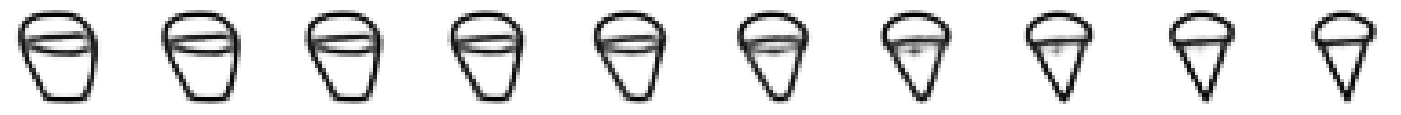

In [93]:
STEPS = 9
INDEX_FROM = 3
INDEX_TO = 17 #10

interpolate(trn_model, images, INDEX_FROM, INDEX_TO, STEPS)

# Latent space visualization

In [88]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

def encode_all(model):
    all_input_vectors, tmp_input_vectors = [],[]
    all_latent_vectors, all_labels = [],[]
    tmp_vectors, tmp_labels = [], []
    
    batch_counter = 0
    
    for batch, labels in train_loader:
        
        # comment out line to encode all training data
        if batch_counter == 300:
            break
        
        for image in batch:
            image.unsqueeze_(0)
            latent_vector = model.reparametrize(*model.encode(image.to(device)))
            
            tmp_vectors.append(latent_vector.unsqueeze(0))
            tmp_input_vectors.append(image)

        tmp_labels.append(labels)
        batch_counter += 1

    latent_vectors = torch.cat(tmp_vectors)
    input_vectors = torch.cat(tmp_input_vectors)
    all_labels = torch.cat(tmp_labels)

    return latent_vectors, all_labels, input_vectors

def plot_tsne_dots(data_encoded, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        palette = sns.color_palette("Paired", labels.unique().shape[0])
        plt.figure(figsize=(16, 14))
        sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette = palette)

            
def plot_tsne_images(data_encoded, input_images, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        fig, ax = plt.subplots(figsize=(16,14))
        ax.scatter(data_embedded[:,0], data_embedded[:,1],c=labels, cmap='Paired')

        for x, y, image in zip(data_embedded[:,0], data_embedded[:,1], input_images):
            ab = AnnotationBbox(OffsetImage(image.squeeze(), cmap="binary_r"), (x, y), frameon=False)
            ax.add_artist(ab)


In [89]:
data_encoded, labels, inputs = encode_all(trn_model)
print(data_encoded.shape)
print(inputs.shape)

torch.Size([19200, 1, 32])
torch.Size([19200, 1, 28, 28])


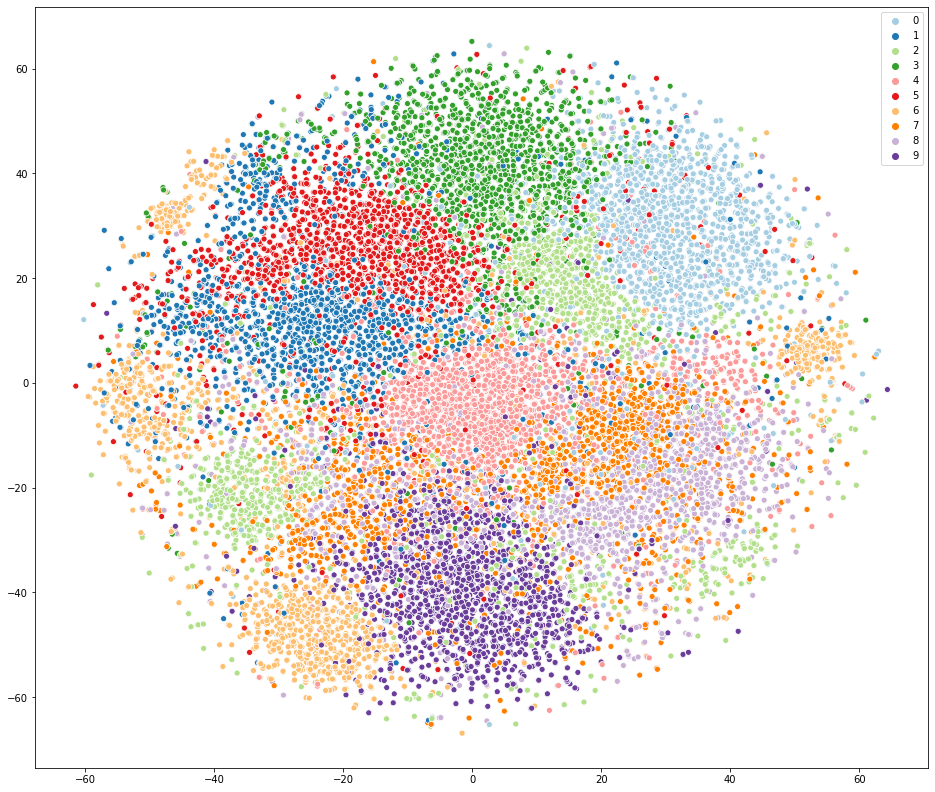

In [90]:
plot_tsne_dots(data_encoded, labels)

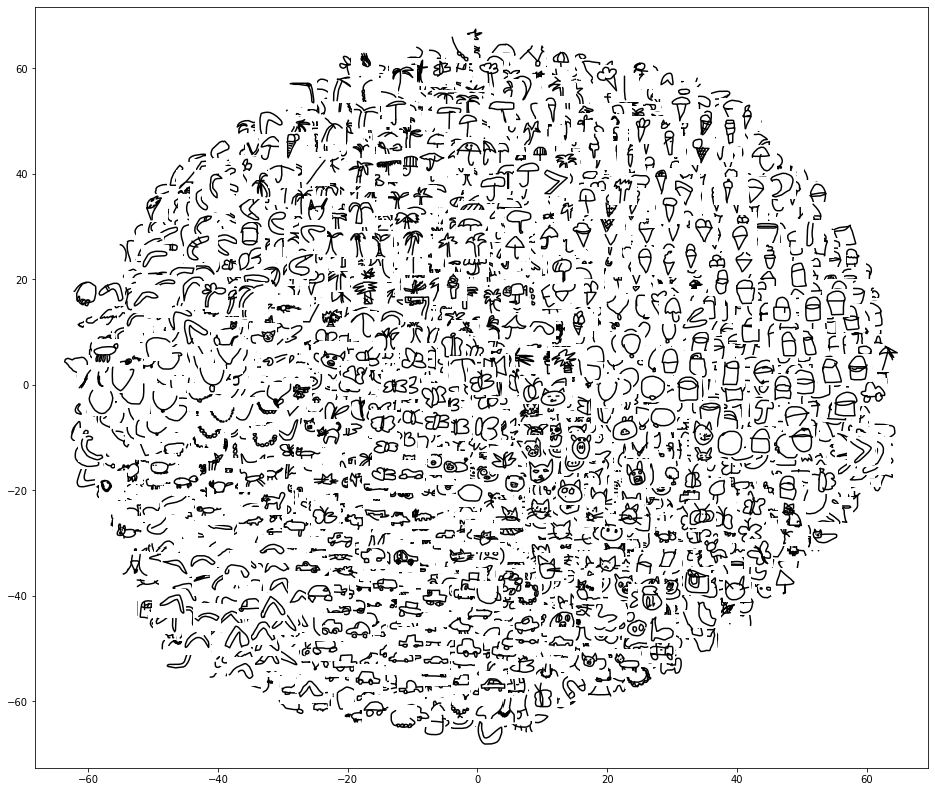

In [91]:
plot_tsne_images(data_encoded, inputs, labels)